In [1]:
import torch
import torch.nn as nn
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import sys
sys.path.append('../src')
from utils import encode_image
from jupyter_bbox_widget import BBoxWidget
import pandas as pd

import cv2
import numpy as np
import supervision as sv

In [2]:
# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "/root/Master_Thesis/sam/sam_vit_h_4b8939.pth"

In [3]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_predictor = SamPredictor(sam)

In [4]:
df = pd.read_csv("/root/Master_Thesis/data/dataframes/brain_df_train.csv")

In [5]:
def getBoxes(image, gt_mask):
    # gt_mask = gt_mask.sum(axis = 2)
    # gt_mask = np.reshape(gt_mask, (gt_mask.shape[0], gt_mask.shape[1], -1))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask_gray = cv2.cvtColor(gt_mask, cv2.COLOR_BGR2GRAY)
    # mask_gray = gt_mask
    ret, thresh = cv2.threshold(mask_gray, 6, 1, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        box = np.array([x, y, x+w, y+h])
        cnts.append(box)
    boxes = torch.Tensor(np.array(cnts)).to(DEVICE)
    transformed_boxes = mask_predictor.transform.apply_boxes_torch(boxes, image_rgb.shape[:2])
    return transformed_boxes                                                                                                                           
    

In [6]:
images = []
masks=[]
i = 0
num =0

while i < len(df) and num <2:
    mask = cv2.imread(df["masks"][i])
    if mask.sum() != 0:
        masks.append(mask)
        images.append(cv2.imread(df["images"][i]))        
        num+=1
    i+=1

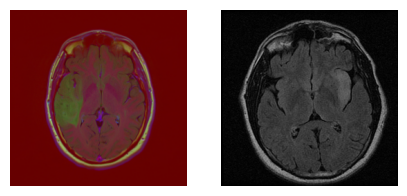

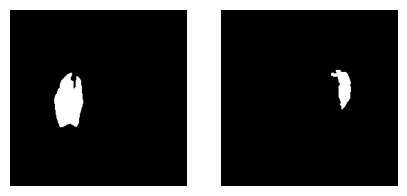

In [7]:
sv.plot_images_grid(
    images=images,
    grid_size=(1, len(images)),
    size=(5,5)
)

sv.plot_images_grid(
    images=masks,
    grid_size=(1, len(masks)),
    size=(5,5)
)

In [8]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device) 
    return image.permute(2, 0, 1).contiguous()

In [9]:
def getBatch(images, masks):
    return [{"image": prepare_image(image, resize_transform, DEVICE),
             "boxes": getBoxes(image, mask),
             "original_size": image.shape[:2]} for image, mask in zip(images, masks)]

In [10]:
batch = getBatch(images, masks)

In [11]:
batched_output = sam(batch, multimask_output=False)

In [12]:
batched_output[0].keys()

dict_keys(['masks', 'iou_predictions', 'low_res_logits'])

In [13]:
output_masks=[]
for i in range(len(batched_output)):
    for mask in batched_output[i]["masks"]:
        mask = mask.sum(axis = 0).cpu().numpy()
        output_masks.append(mask)

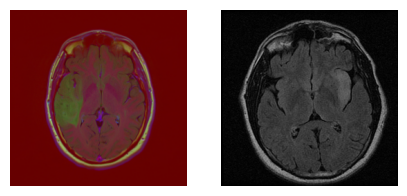

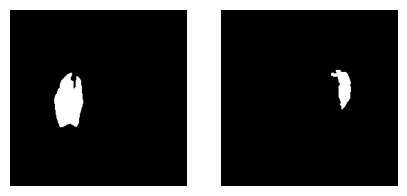

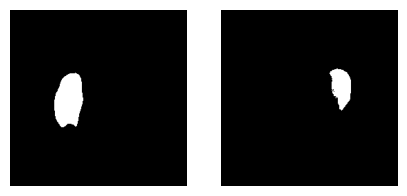

In [14]:
sv.plot_images_grid(
    images=images,
    grid_size=(1, len(images)),
    size=(5,5)
)

sv.plot_images_grid(
    images=masks,
    grid_size=(1, len(masks)),
    size=(5,5)
)
sv.plot_images_grid(
    images=output_masks,
    grid_size=(1, 2),
    size=(5,5)
)